# Libraries and definitions

In [1]:
import pandas as pd
import numpy as np
from os.path import join
from matplotlib import pyplot as plt
#from xgboost import XGBClassifier

In [2]:
DATA_DIR = 'data'
DATA_FILE = join(DATA_DIR,'covid_data_2.csv')

In [3]:
REF_DATE = pd.to_datetime('2022-01-01')
SCALE = True
APPLY_PCA = False
DATA_TYPE = 2
FILTER_MI = False

# Preprocess data

## Filter data

In [4]:
def filter_data_date(data,reference_date = REF_DATE):
    '''For each person (record_id), get only the row with the visit date closest to reference_date'''
    data['visit_date'] = pd.to_datetime(data['visit_date'])
    data = data.dropna(subset=['visit_date'],ignore_index = True)
    data = data[data['visit_date'] < reference_date]
    return data.sort_values(by=['record_id','visit_date'],ascending = [True,False]).drop_duplicates(subset=['record_id'], keep='first')#.reset_index()


In [5]:
all_data = pd.read_csv(DATA_FILE)
raw_data = filter_data_date(all_data).dropna(axis=1, how='all') #apply date filter and remove empty columns
raw_data.pop('visit_date')
raw_data.pop('index_date')
raw_data.set_index('record_id',inplace=True)
assert (all_data['record_id'].unique() == raw_data.index).all()

In [6]:
raw_data

,Unnamed: 0,final_outcome_amp,timepoint,study,pop_sample,age,sex,bmi,smoking,comorbidity,...,last_antibody_before_omicron_igg_s_logratio,last_antibody_before_omicron_iga_log10ratio,last_antibody_before_omicron_igg_n_log10ratio,last_antibody_before_omicron_igg_s_log10ratio,last_antibody_before_omicron_iga_ratio,last_antibody_before_omicron_igg_n_ratio,last_antibody_before_omicron_igg_s_ratio,prior_hyg,prior_dist,prior_mask_mand
record_id,,,,,,,,,,,,,,,,,,,,,
1,4,1,M12,ZSAC,prospective,23,female,24.618104,Non-smoker,No,...,3.887730,0.416300,0.000000,1.688420,2.607955,1.0,48.8,7.0,2.0,7.0
2,11,1,M12,ZSAC,prospective,51,male,26.643599,Ex-smoker,Yes,...,3.772761,0.547579,0.000000,1.638489,3.528409,1.0,43.5,7.0,6.0,7.0
3,18,1,M12,ZSAC,prospective,36,male,23.190497,Non-smoker,No,...,4.409155,1.654363,0.000000,1.914872,45.119318,1.0,82.2,7.0,5.0,7.0
5,25,0,M12,ZSAC,prospective,53,female,21.147691,Non-smoker,No,...,4.036009,0.893421,0.000000,1.752816,7.823864,1.0,56.6,6.0,6.0,7.0
8,32,1,M12,ZSAC,prospective,32,female,23.634033,Non-smoker,No,...,4.442651,1.409145,0.230449,1.929419,25.653409,1.7,85.0,7.0,4.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5409,5160,1,M6,ZVAC,Moderna,39,female,22.582709,Smoker,No,...,4.476200,1.609407,0.079181,1.943989,40.682432,1.2,87.9,7.0,6.0,6.0
5410,5167,0,M6,ZVAC,Moderna,47,female,20.281233,Smoker,No,...,4.364372,1.326806,0.000000,1.895423,21.222973,1.0,78.6,7.0,5.0,7.0
5411,5175,0,M6,ZVAC,Moderna,47,male,23.728048,Smoker,No,...,4.374498,1.198954,0.000000,1.899821,15.810811,1.0,79.4,7.0,6.0,7.0


In [7]:
y = raw_data.pop('final_outcome_amp')
raw_data.head()

,Unnamed: 0,timepoint,study,pop_sample,age,sex,bmi,smoking,comorbidity,hypertension,...,last_antibody_before_omicron_igg_s_logratio,last_antibody_before_omicron_iga_log10ratio,last_antibody_before_omicron_igg_n_log10ratio,last_antibody_before_omicron_igg_s_log10ratio,last_antibody_before_omicron_iga_ratio,last_antibody_before_omicron_igg_n_ratio,last_antibody_before_omicron_igg_s_ratio,prior_hyg,prior_dist,prior_mask_mand
record_id,,,,,,,,,,,,,,,,,,,,,
1,4,M12,ZSAC,prospective,23,female,24.618104,Non-smoker,No,No,...,3.887730,0.416300,0.000000,1.688420,2.607955,1.0,48.8,7.0,2.0,7.0
2,11,M12,ZSAC,prospective,51,male,26.643599,Ex-smoker,Yes,No,...,3.772761,0.547579,0.000000,1.638489,3.528409,1.0,43.5,7.0,6.0,7.0
3,18,M12,ZSAC,prospective,36,male,23.190497,Non-smoker,No,No,...,4.409155,1.654363,0.000000,1.914872,45.119318,1.0,82.2,7.0,5.0,7.0
5,25,M12,ZSAC,prospective,53,female,21.147691,Non-smoker,No,No,...,4.036009,0.893421,0.000000,1.752816,7.823864,1.0,56.6,6.0,6.0,7.0
8,32,M12,ZSAC,prospective,32,female,23.634033,Non-smoker,No,No,...,4.442651,1.409145,0.230449,1.929419,25.653409,1.7,85.0,7.0,4.0,7.0


## Convert variables

In [8]:
def scale(x:pd.Series):
    if SCALE:
        return (x - x.mean()) / x.std()
    else: return x
# To binary variables that have nan values, what to do with them?
raw_data.columns[raw_data.isnull().any()]

Index(['bmi', 'hypertension', 'diabetes', 'cvd', 'respiratory', 'ckd',
       'cancer', 'immune_supp', 'income_3l', 'education_4l', 'symp_init',
       'symp_count_init_3l', 'symp_sev_init_3l', 'hosp_2wks', 'icu_2wks',
       'prior_pos_pcr', 'first_exposure_date', 'vaccine_date_1',
       'vaccine_date_2', 'vaccine_date_3', 'vaccine_date_4', 'vaccine_type_1',
       'vaccine_type_2', 'vaccine_type_3', 'vaccine_type_4', 'pcr_pos_date_1',
       'pcr_pos_date_2', 'pcr_pos_sev_1', 'prior_hyg', 'prior_dist',
       'prior_mask_mand'],
      dtype='object')

In [9]:
data = raw_data.copy()
if DATA_TYPE == 1:
    for c in data.columns:
        if data[c].dtype in ['object','datetime64[ns]']: 
            try: data[c] = (REF_DATE - pd.to_datetime(data[c], format='%Y-%m-%d')).dt.days
            except: 
                if len(data[c].unique()) == 2:
                    data[c] = data[c].map({data[c].unique()[0]:0,data[c].unique()[1]:1})
                else: #Test also the possibility of label encoding for some ordinal variables
                    data = pd.get_dummies(data, columns=[c], dtype=int)
            else:
                assert ((data[c]>0) | data[c].isna()).all()
                data[c] = data[c].fillna(-1).astype(int)
    data.fillna(data.mean(), inplace=True)
elif DATA_TYPE == 2:
    data = pd.get_dummies(data, columns=['timepoint'], dtype=int)
    data['study'] = data['study'].map({data['study'].unique()[0]:0,data['study'].unique()[1]:1})
    data = pd.get_dummies(data, columns=['pop_sample'], dtype=int)
    #data['visit_date'] = (REF_DATE - pd.to_datetime(data['visit_date'], format='%Y-%m-%d')).dt.days
    #data['index_date'] = (REF_DATE - pd.to_datetime(data['index_date'], format='%Y-%m-%d')).dt.days
    data['age'] = scale(data['age'])#normalize age?
    data['sex'] = data['sex'].map({data['sex'].unique()[0]:0,data['sex'].unique()[1]:1})
    data['bmi'] = scale(data['bmi']).fillna(data['bmi'].mean())
    data = pd.get_dummies(data, columns=['smoking'], dtype=int) #or adapt to 0, 0.5 and 1?
    data['comorbidity'] = data['comorbidity'].map({data['comorbidity'].unique()[0]:0,data['comorbidity'].unique()[1]:1})
    data['hypertension'] = data['hypertension'].map({data['hypertension'].unique()[0]:0,data['hypertension'].unique()[1]:1})
    data['hypertension'] = data['hypertension'].fillna(data['hypertension'].mean())
    data['diabetes'] = data['diabetes'].map({data['diabetes'].unique()[0]:0,data['diabetes'].unique()[1]:1})
    data['diabetes'] = data['diabetes'].fillna(data['diabetes'].mean())
    data['cvd'] = data['cvd'].map({data['cvd'].unique()[0]:0,data['cvd'].unique()[1]:1})
    data['cvd'] = data['cvd'].fillna(data['cvd'].mean())
    data['respiratory'] = data['respiratory'].map({data['respiratory'].unique()[0]:0,data['respiratory'].unique()[1]:1})
    data['respiratory'] = data['respiratory'].fillna(data['respiratory'].mean())
    data['ckd'] = data['ckd'].map({data['ckd'].unique()[0]:0,data['ckd'].unique()[1]:1})
    data['ckd'] = data['ckd'].fillna(data['ckd'].mean())
    data['cancer'] = data['cancer'].map({data['cancer'].unique()[0]:0, data['cancer'].unique()[1]:1})
    data['cancer'] = data['cancer'].fillna(data['cancer'].mean())
    data['immune_supp'] = data['immune_supp'].map({data['immune_supp'].unique()[0]:0, data['immune_supp'].unique()[1]:1})
    data['immune_supp'] = data['immune_supp'].fillna(data['immune_supp'].mean())
    data = pd.get_dummies(data,columns=['income_3l'], dummy_na=0, dtype=int)#data['income_3l'].map({"<6'000 CHF":0, "6'000 - 12'000 CHF":0.5, ">12'000 CHF":1}).fillna(0.5) ####
    data = pd.get_dummies(data, columns=['employment_4l'], dtype=int)
    data = pd.get_dummies(data,columns=['education_4l'], prefix='education', dummy_na=0, dtype=int)
    data['nationality'] = data['nationality'].map({'Non-Swiss':0,'Swiss':1})
    data['summary_bl_behaviour'] = scale(data['summary_bl_behaviour'])
    data['symp_init'] = data['symp_init'].map({"No":0, "Yes":1})
    data['symp_init'] = data['symp_init'].fillna(data['symp_init'].mean())
    data = pd.get_dummies(data,columns=['symp_count_init_3l'], dummy_na=0, dtype=int) #####
    data['symp_sev_init_3l'] = data['symp_sev_init_3l'].map({"Mild to moderate":0, "Severe to very severe":1})
    data['symp_sev_init_3l'] = data['symp_sev_init_3l'].fillna(data['symp_sev_init_3l'].mean())
    data['hosp_2wks'] = data['hosp_2wks'].map({"No":0, "Yes":1})
    data['hosp_2wks'] = data['hosp_2wks'].fillna(data['hosp_2wks'].mean())
    data['icu_2wks'] = data['icu_2wks'].map({"No":0, "Yes":1})
    data['icu_2wks'] = data['icu_2wks'].fillna(data['icu_2wks'].mean()) #can discard?
    data['seropos_at_bl'] = data['seropos_at_bl'].map({"No":0, "Yes":1})
    data['seropos_at_bl'] = data['seropos_at_bl'].fillna(data['seropos_at_bl'].mean())
    data['prior_pos_pcr'] = data['prior_pos_pcr'].map({"No":0, "Yes":1})
    data['prior_pos_pcr'] = data['prior_pos_pcr'].fillna(data['prior_pos_pcr'].mean())
    data['prior_exposure'] = data['prior_exposure'].map({"No":0, "Yes":1})
    data['prior_exposure'] = data['prior_exposure'].fillna(data['prior_exposure'].mean())
    data['first_exposure_date'] = (REF_DATE - pd.to_datetime(data['first_exposure_date'], format='%Y-%m-%d')).dt.days; 
    data['first_exposure_date'] = data['first_exposure_date'].fillna(data['first_exposure_date'].mean())
    data['first_exposure'] = data['first_exposure'].map({data['first_exposure'].unique()[0]:0,data['first_exposure'].unique()[1]:1}).fillna(0.5)
    data= pd.get_dummies(data,columns=['vaccine_type_1'], dummy_na=0, dtype=int)#data['vaccine_type_1'].map({"Moderna":0, "Pfizer/BioNTech":1, "Other":0.5}).fillna(-1) 
    data = pd.get_dummies(data,columns=['vaccine_type_2'], dummy_na=0, dtype=int)#data['vaccine_type_2'].map({"Moderna":0, "Pfizer/BioNTech":1, "Other":0.5}).fillna(-1)
    data = pd.get_dummies(data,columns=['vaccine_type_3'], dummy_na=0, dtype=int)#data['vaccine_type_3'].map({"Moderna":0, "Pfizer/BioNTech":1, "Other":0.5}).fillna(-1)
    data = pd.get_dummies(data,columns=['vaccine_type_4'], dummy_na=0, dtype=int)#data['vaccine_type_4'].map({"Moderna":0, "Pfizer/BioNTech":1, "Other":0.5}).fillna(-1) 
    data['pcr_pos_date_1'] = (REF_DATE - pd.to_datetime(data['pcr_pos_date_1'], format='%Y-%m-%d')).dt.days; 
    data['pcr_pos_date_1'] = data['pcr_pos_date_1'].fillna(data['pcr_pos_date_1'].mean())
    data['pcr_pos_date_2'] = (REF_DATE - pd.to_datetime(data['pcr_pos_date_2'], format='%Y-%m-%d')).dt.days; 
    data['pcr_pos_date_2'] = data['pcr_pos_date_2'].fillna(data['pcr_pos_date_2'].mean())
    data= pd.get_dummies(data,columns=['pcr_pos_sev_1'], dummy_na=0, dtype=int)#data['pcr_pos_sev_1'].map({"Very mild":1, "Mild":2, "Moderate":3, "Severe":4}).fillna(-1) 
    data['ab_chuv_iga_ratio'] = scale(data['ab_chuv_iga_ratio'])
    #data.drop('ab_chuv_iga_logratio', axis=1, inplace=True)
    data['ab_chuv_iga_result'] = data['ab_chuv_iga_result'].map({data['ab_chuv_iga_result'].unique()[0]:0,data['ab_chuv_iga_result'].unique()[1]:1})
    #data.drop('ab_chuv_iga_log10ratio', axis=1, inplace=True)
    data['ab_chuv_igg_s_ratio'] = scale(data['ab_chuv_igg_s_ratio'])
    #data.drop('ab_chuv_igg_s_logratio', axis=1, inplace=True)
    data['ab_chuv_igg_s_result'] = data['ab_chuv_igg_s_result'].map({data['ab_chuv_igg_s_result'].unique()[0]:0,data['ab_chuv_igg_s_result'].unique()[1]:1})
    #data.drop('ab_chuv_igg_s_log10ratio', axis=1, inplace=True)
    data['ab_chuv_igg_n_ratio'] = scale(data['ab_chuv_igg_n_ratio'])
    #data.drop('ab_chuv_igg_n_logratio', axis=1, inplace=True)
    data['ab_chuv_igg_n_result'] = data['ab_chuv_igg_n_result'].map({data['ab_chuv_igg_n_result'].unique()[0]:0,data['ab_chuv_igg_n_result'].unique()[1]:1})
    #data.drop('ab_chuv_igg_n_log10ratio', axis=1, inplace=True)
    data['last_antibody_before_omicron_iga_logratio'] = scale(data['last_antibody_before_omicron_iga_logratio'])
    data['last_antibody_before_omicron_igg_n_logratio'] = scale(data['last_antibody_before_omicron_igg_n_logratio'])
    data['last_antibody_before_omicron_igg_s_logratio'] = scale(data['last_antibody_before_omicron_igg_s_logratio'])
    data.drop('Unnamed: 0', inplace=True,axis=1)
    data['vaccine_date_1'] = (REF_DATE - pd.to_datetime(data['vaccine_date_1'], format='%Y-%m-%d')).dt.days; 
    data['vaccine_date_1'] = data['vaccine_date_1'].fillna(-100)
    data['vaccine_date_2'] = (REF_DATE - pd.to_datetime(data['vaccine_date_2'], format='%Y-%m-%d')).dt.days
    data['vaccine_date_2'] = data['vaccine_date_2'].fillna(-100); 
    data['vaccine_date_3'] = (REF_DATE - pd.to_datetime(data['vaccine_date_3'], format='%Y-%m-%d')).dt.days; 
    data['vaccine_date_3'] = data['vaccine_date_3'].fillna(-100)
    data['vaccine_date_4'] = (REF_DATE - pd.to_datetime(data['vaccine_date_4'], format='%Y-%m-%d')).dt.days; 
    data['vaccine_date_4'] = data['vaccine_date_4'].fillna(-100)
    data['prior_hyg'] = data['prior_hyg'].fillna(0.)
    data['prior_dist'] = data['prior_hyg'].fillna(0.)
    data['prior_mask_mand'] = data['prior_hyg'].fillna(0.)


## Divide dataset

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.15, random_state=11, stratify=y)

In [11]:
from sklearn.feature_selection import mutual_info_classif

# Calculate mutual information
MI = pd.Series(mutual_info_classif(X_train, y_train), index=X_train.columns)

# Filter data to be the data with the highest MI with the column 'covid'
X_train = X_train.loc[:, MI > 0]
X_test = X_test.loc[:, MI > 0]

# Filter data to be the data with the highest MI with the column 'covid'
#top_features = MI.nlargest().index
#X_train = data[top_features]
#print(filtered_data.head())

In [12]:
X_train.shape, X_test.shape

((603, 44), (107, 44))

## Preprocessing

In [13]:
from sklearn.preprocessing import StandardScaler
if SCALE:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

## PCA

In [14]:
from sklearn.decomposition import PCA

if APPLY_PCA:
    pca = PCA(n_components=0.95)  # 0.95 means we want to keep enough components to explain 95% of the variance
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    # Check how much variance each component explains
    print(pca.explained_variance_ratio_)
    print(f"Number of components selected: {pca.n_components_}")

# Models

In [15]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

## Decision Tree

In [16]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5,10, 20, 30, 40, 50,100,200],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'splitter': ['best', 'random'],
    'criterion': ['gini', 'entropy']
}
# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, scoring='balanced_accuracy')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 20, 30, 40, 50, 100, 200],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             scoring='balanced_accuracy')

In [17]:
from sklearn.model_selection import cross_val_score

# results
best_estimator = grid_search.best_estimator_
print(f"Best params = {grid_search.best_params_}")
# Predict on the test data
y_pred = best_estimator.predict(X_test)
print('Test Accuracy:', accuracy_score(y_test, y_pred))
print('Test AUROC:', roc_auc_score(y_test, y_pred))
print('Test Classification Report:\n', classification_report(y_test, y_pred))

# Perform cross-validation and calculate the mean ROC AUC score
cv_scores = cross_val_score(best_estimator, X_train, y_train, cv=5, scoring='roc_auc')
print('Cross-validated ROC AUC scores:', cv_scores)
print('Mean cross-validated ROC AUC score:', cv_scores.mean())

# Predict on the train data
y_train_pred = best_estimator.predict(X_train)
print('Train Accuracy:', accuracy_score(y_train, y_train_pred))
print('Train AUROC:', roc_auc_score(y_train, y_train_pred))
print('Train Classification Report:\n', classification_report(y_train, y_train_pred))

Best params = {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}
Test Accuracy: 0.6355140186915887
Test AUROC: 0.5830223880597015
Test Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.79      0.73        67
           1       0.52      0.38      0.43        40

    accuracy                           0.64       107
   macro avg       0.60      0.58      0.58       107
weighted avg       0.62      0.64      0.62       107

Cross-validated ROC AUC scores: [0.54605263 0.62982456 0.57909357 0.57655502 0.62296296]
Mean cross-validated ROC AUC score: 0.5908977494240653
Train Accuracy: 0.724709784411277
Train AUROC: 0.690627355823596
Train Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.82      0.79       379
           1       0.65      0.56      0.60       224

    accuracy                           0.72       603

## Random Forest

In [18]:
model = RandomForestClassifier(n_estimators=2000)
model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=2000)

### Evaluate

In [19]:

# Predict on the test data
y_pred = model.predict(X_test)
print('Test Accuracy:', accuracy_score(y_test, y_pred))
print('Test AUROC:', roc_auc_score(y_test, y_pred))
print('Test Classification Report:\n', classification_report(y_test, y_pred))

cv_scores = cross_val_score(best_estimator, X_train, y_train, cv=5, scoring='roc_auc')
print('Cross-validated ROC AUC scores:', cv_scores)
print('Mean cross-validated ROC AUC score:', cv_scores.mean())

# Predict on the train data
y_train_pred = model.predict(X_train)
print('Train Accuracy:', accuracy_score(y_train, y_train_pred))
print('Train AUROC:', roc_auc_score(y_train, y_train_pred))
print('Train Classification Report:\n', classification_report(y_train, y_train_pred))

Test Accuracy: 0.6448598130841121
Test AUROC: 0.5955223880597015
Test Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.79      0.74        67
           1       0.53      0.40      0.46        40

    accuracy                           0.64       107
   macro avg       0.61      0.60      0.60       107
weighted avg       0.63      0.64      0.63       107

Cross-validated ROC AUC scores: [0.54605263 0.62982456 0.57909357 0.57655502 0.62296296]
Mean cross-validated ROC AUC score: 0.5908977494240653
Train Accuracy: 1.0
Train AUROC: 1.0
Train Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       379
           1       1.00      1.00      1.00       224

    accuracy                           1.00       603
   macro avg       1.00      1.00      1.00       603
weighted avg       1.00      1.00      1.00       603



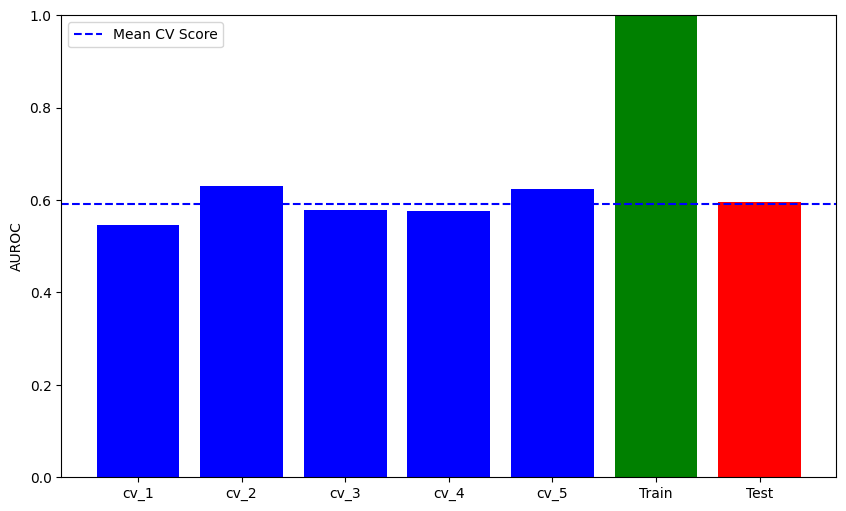

In [20]:
x_labels = ['cv_1', 'cv_2', 'cv_3', 'cv_4', 'cv_5', 'Train', 'Test']

# Y-axis values corresponding to the labels
y_values = np.r_[cv_scores,roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_pred)]

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(x_labels, y_values, color=['blue', 'blue', 'blue', 'blue', 'blue', 'green', 'red'])
plt.axhline(np.mean(cv_scores), color='blue', linestyle='--', label='Mean CV Score')
# Add labels and title
plt.ylabel("AUROC")
plt.ylim(0, 1)
plt.legend()

# Show plot
plt.show()

In [21]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [None, 5,10, 20, 30, 40],
    'min_samples_split': [5, 7,10,12,20],
    'min_samples_leaf': [3,4,5,6,7,8],
    'max_features': [ 'sqrt', 'log2'],
    'n_estimators': [10,20,30,40]#,100, 200]#, 300, 500,1000, 1700],
}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 5, 10, 20, 30, 40],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [3, 4, 5, 6, 7, 8],
                         'min_samples_split': [5, 7, 10, 12, 20],
                         'n_estimators': [10, 20, 30, 40]},
             scoring='roc_auc')

In [22]:
# results
best_estimator = grid_search.best_estimator_
print(f"Best params = {grid_search.best_params_}")
# save best params
y_pred = best_estimator.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('AUROC:', roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cv_scores = cross_val_score(best_estimator, X_train, y_train, cv=5, scoring='roc_auc')
print('Cross-validated ROC AUC scores:', cv_scores)
print('Mean cross-validated ROC AUC score:', cv_scores.mean())
# Predict on the train data
y_train_pred = model.predict(X_train)
print('Train Accuracy:', accuracy_score(y_train, y_train_pred))
print('Train AUROC:', roc_auc_score(y_train, y_train_pred))
print('Train Classification Report:\n', classification_report(y_train, y_train_pred))

Best params = {'bootstrap': False, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 10}
Accuracy: 0.5981308411214953
AUROC: 0.5128731343283582
              precision    recall  f1-score   support

           0       0.63      0.85      0.73        67
           1       0.41      0.17      0.25        40

    accuracy                           0.60       107
   macro avg       0.52      0.51      0.49       107
weighted avg       0.55      0.60      0.55       107

Cross-validated ROC AUC scores: [0.56754386 0.60701754 0.63230994 0.69557416 0.65318519]
Mean cross-validated ROC AUC score: 0.6311261385787701
Train Accuracy: 1.0
Train AUROC: 1.0
Train Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       379
           1       1.00      1.00      1.00       224

    accuracy                           1.00       603
   macro avg       1.00      1.00      1.00   

In [23]:
#importances = best_estimator.feature_importances_
#feature_names = X_test.columns
#feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
#print(feature_imp_df)

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

# Assuming best_estimator is the trained model from GridSearchCV
# And y_test and X_test are the test labels and features
# Example usage: plot_confusion_matrix(best_estimator, X_test, y_test)

def plot_confusion_matrix(best_estimator, X_test, y_test):
    # Get predictions for the test set
    y_pred = best_estimator.predict(X_test)

    # Plot the confusion matrix
    ConfusionMatrixDisplay.from_estimator(best_estimator, X_test, y_test, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()
def plot_roc_curve(best_estimator, X_test, y_test):
    # Get predicted probabilities for the positive class
    y_prob = best_estimator.predict_proba(X_test)[:, 1]  # Use [:, 1] for positive class probabilities

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

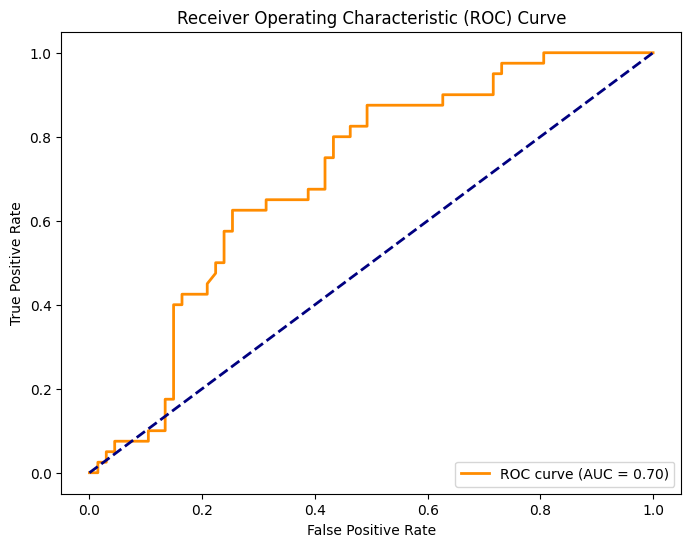

In [25]:
plot_roc_curve(best_estimator, X_test, y_test)

In [26]:
cv_scores

array([0.56754386, 0.60701754, 0.63230994, 0.69557416, 0.65318519])

In [27]:
roc_auc_score(y_test, y_pred)
roc_auc_score(y_train, y_train_pred)

1.0

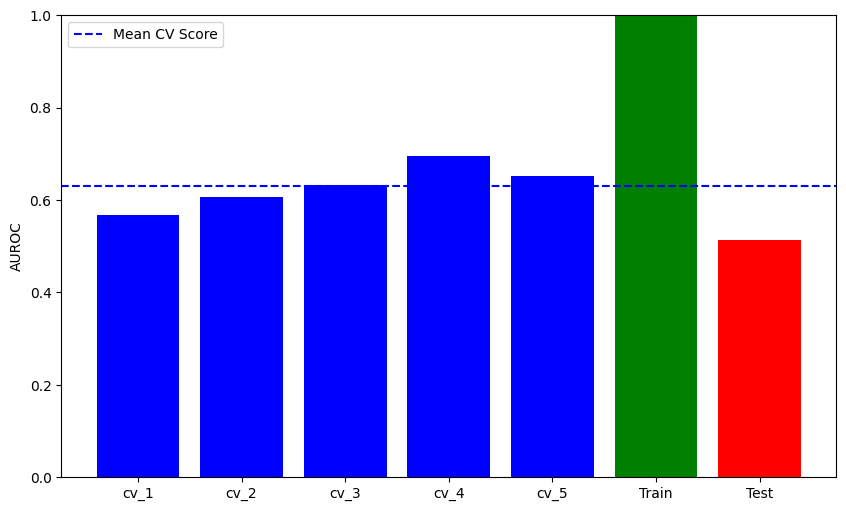

In [28]:
x_labels = ['cv_1', 'cv_2', 'cv_3', 'cv_4', 'cv_5', 'Train', 'Test']

# Y-axis values corresponding to the labels
y_values = np.r_[cv_scores,roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_pred)]

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(x_labels, y_values, color=['blue', 'blue', 'blue', 'blue', 'blue', 'green', 'red'])
plt.axhline(np.mean(cv_scores), color='blue', linestyle='--', label='Mean CV Score')
# Add labels and title
plt.ylabel("AUROC")
plt.ylim(0, 1)
plt.legend()

# Show plot
plt.show()

## GradientBoosting

In [29]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)


GradientBoostingClassifier()

In [30]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('AUROC:', roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Predict on the train data
y_train_pred = model.predict(X_train)
print('Train Accuracy:', accuracy_score(y_train, y_train_pred))
print('Train AUROC:', roc_auc_score(y_train, y_train_pred))
print('Train Classification Report:\n', classification_report(y_train, y_train_pred))

Accuracy: 0.6448598130841121
AUROC: 0.5955223880597015
              precision    recall  f1-score   support

           0       0.69      0.79      0.74        67
           1       0.53      0.40      0.46        40

    accuracy                           0.64       107
   macro avg       0.61      0.60      0.60       107
weighted avg       0.63      0.64      0.63       107

Train Accuracy: 0.8805970149253731
Train AUROC: 0.8475016490765171
Train Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91       379
           1       0.95      0.72      0.82       224

    accuracy                           0.88       603
   macro avg       0.90      0.85      0.86       603
weighted avg       0.89      0.88      0.88       603



In [31]:
model_configs = {
    'random_state':51,
}
# model params
model_params = {
    'max_depth': [2, 5, 15, 20],
    'min_samples_leaf': [2, 25, 50],
}
# search parameters
serch_params = {
    'scoring': 'balanced_accuracy',
    'return_train_score':True,
    'n_jobs':-1,
}

# runs random search
reg = GridSearchCV(GradientBoostingClassifier(**model_configs),
                         model_params, **serch_params)
search = reg.fit(X_train, y_train)

Best score = 0.5989670388091441
Best params = {'max_depth': 15, 'min_samples_leaf': 2}
Accuracy: 0.6542056074766355
AUROC: 0.6832089552238806
              precision    recall  f1-score   support

           0       0.71      0.76      0.73        67
           1       0.54      0.47      0.51        40

    accuracy                           0.65       107
   macro avg       0.63      0.62      0.62       107
weighted avg       0.65      0.65      0.65       107

Validation ROC AUC Scores (Mean per Param Combination): [0.56698777 0.56309304 0.57857629 0.58582562 0.56976289 0.56599894
 0.59896704 0.57309676 0.56275173 0.5730925  0.57309676 0.56275173]
Validation ROC AUC Std Dev: [0.02885281 0.02938794 0.02741229 0.03686264 0.03594352 0.02396183
 0.04519278 0.0319469  0.02831798 0.03168693 0.0319469  0.02831798]
Train Accuracy: 1.0
Train AUROC: 1.0
Train Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       379
 

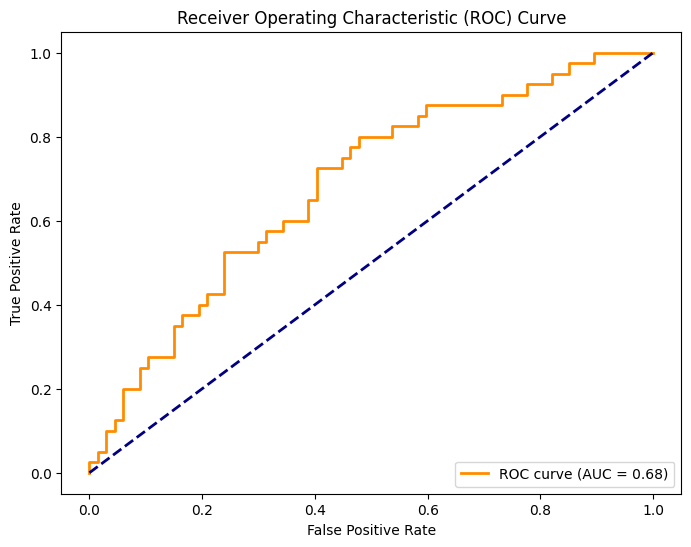

In [32]:
# results
best_estimator = search.best_estimator_
print(f"Best score = {search.best_score_}")
print(f"Best params = {search.best_params_}")
# save best params
rf_best_params =  {**model_configs, **search.best_params_}

y_pred = best_estimator.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('AUROC:', roc_auc_score(y_test, best_estimator.predict_proba(X_test)[:,1]))
print(classification_report(y_test, y_pred))

cv_results = search.cv_results_
val_roc_auc_scores = cv_results['mean_test_score']
val_roc_auc_std = cv_results['std_test_score']
print("Validation ROC AUC Scores (Mean per Param Combination):", val_roc_auc_scores)
print("Validation ROC AUC Std Dev:", val_roc_auc_std)
# Predict on the train data
y_train_pred = best_estimator.predict(X_train)
print('Train Accuracy:', accuracy_score(y_train, y_train_pred))
print('Train AUROC:', roc_auc_score(y_train, best_estimator.predict_proba(X_train)[:,1]))
print('Train Classification Report:\n', classification_report(y_train, y_train_pred))

plot_roc_curve(best_estimator, X_test, y_test)

In [33]:
# Get ROC AUC scores for each validation split
folds = [key for key in cv_results.keys() if key.startswith('split') and key.endswith('_test_score')]
fold_scores = {fold: cv_results[fold] for fold in folds}

for fold, scores in fold_scores.items():
    print(f"{fold}: {scores}")

split0_test_score: [0.51944444 0.50833333 0.53464912 0.54780702 0.5128655  0.52149123
 0.53011696 0.57704678 0.56140351 0.53216374 0.57704678 0.56140351]
split1_test_score: [0.57002924 0.57046784 0.59678363 0.62149123 0.57090643 0.57046784
 0.63055556 0.56637427 0.59473684 0.57953216 0.56637427 0.59473684]
split2_test_score: [0.59883041 0.59429825 0.60994152 0.63011696 0.61900585 0.58567251
 0.56096491 0.63011696 0.58567251 0.55233918 0.63011696 0.58567251]
split3_test_score: [0.59330144 0.58014354 0.59150718 0.58971292 0.59270335 0.58791866
 0.6465311  0.55861244 0.55861244 0.57476077 0.55861244 0.55861244]
split4_test_score: [0.55333333 0.56222222 0.56       0.54       0.55333333 0.56444444
 0.62666667 0.53333333 0.51333333 0.62666667 0.53333333 0.51333333]


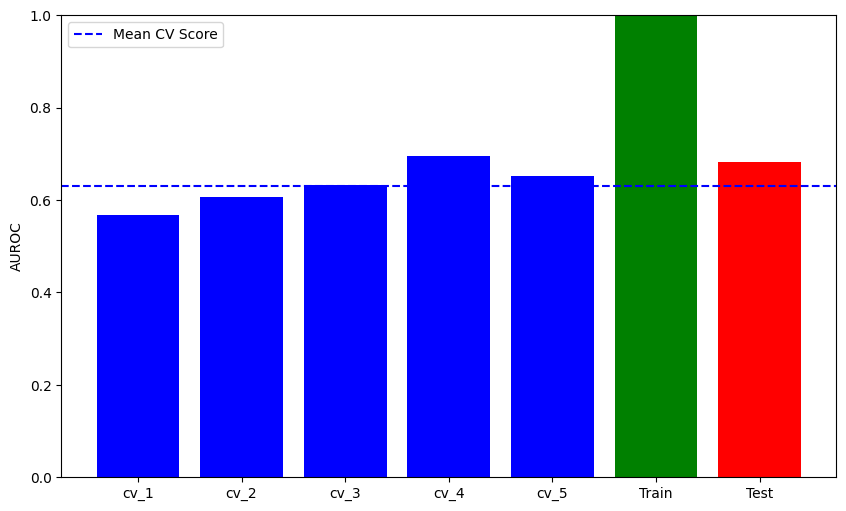

In [34]:
x_labels = ['cv_1', 'cv_2', 'cv_3', 'cv_4', 'cv_5', 'Train', 'Test']

# Y-axis values corresponding to the labels
y_values = np.r_[cv_scores,roc_auc_score(y_train, best_estimator.predict_proba(X_train)[:,1]), roc_auc_score(y_test, best_estimator.predict_proba(X_test)[:,1])]

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(x_labels, y_values, color=['blue', 'blue', 'blue', 'blue', 'blue', 'green', 'red'])
plt.axhline(np.mean(cv_scores), color='blue', linestyle='--', label='Mean CV Score')
# Add labels and title
plt.ylabel("AUROC")
plt.ylim(0, 1)
plt.legend()

# Show plot
plt.show()

## SVC

In [35]:
from sklearn.svm import SVC

# Initialize the SVM model with a linear kernel
svm_model = SVC(C= 0.05, degree = 1, gamma= 'scale',kernel='linear', random_state=42)

# Train the model on the training data
svm_model.fit(X_train, y_train)

SVC(C=0.05, degree=1, kernel='linear', random_state=42)

In [36]:
# Predict on the test data
y_pred = svm_model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('AUROC:', roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


# Predict on the train data
y_train_pred = model.predict(X_train)
print('Train Accuracy:', accuracy_score(y_train, y_train_pred))
print('Train AUROC:', roc_auc_score(y_train, y_train_pred))
print('Train Classification Report:\n', classification_report(y_train, y_train_pred))

Accuracy: 0.616822429906542
AUROC: 0.5177238805970149
              precision    recall  f1-score   support

           0       0.64      0.91      0.75        67
           1       0.45      0.12      0.20        40

    accuracy                           0.62       107
   macro avg       0.54      0.52      0.47       107
weighted avg       0.57      0.62      0.54       107

Train Accuracy: 0.8805970149253731
Train AUROC: 0.8475016490765171
Train Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91       379
           1       0.95      0.72      0.82       224

    accuracy                           0.88       603
   macro avg       0.90      0.85      0.86       603
weighted avg       0.89      0.88      0.88       603



In [37]:
param_grid = {
    'C': [0.1,0.2,0.3,0.4,0.5, 1.],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.1, 1,10],
    'degree': [1,2, 3, 4],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=10)

# Fit the grid search
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV 1/5; 1/240] START C=0.1, degree=1, gamma=scale, kernel=linear...............
[CV 2/5; 1/240] START C=0.1, degree=1, gamma=scale, kernel=linear...............
[CV 3/5; 1/240] START C=0.1, degree=1, gamma=scale, kernel=linear...............
[CV 4/5; 1/240] START C=0.1, degree=1, gamma=scale, kernel=linear...............
[CV 5/5; 1/240] START C=0.1, degree=1, gamma=scale, kernel=linear...............
[CV 2/5; 1/240] END C=0.1, degree=1, gamma=scale, kernel=linear;, score=0.631 total time=   0.0s
[CV 1/5; 2/240] START C=0.1, degree=1, gamma=scale, kernel=rbf..................
[CV 2/5; 2/240] START C=0.1, degree=1, gamma=scale, kernel=rbf..................
[CV 1/5; 1/240] END C=0.1, degree=1, gamma=scale, kernel=linear;, score=0.604 total time=   0.0s
[CV 3/5; 1/240] END C=0.1, degree=1, gamma=scale, kernel=linear;, score=0.592 total time=   0.0s
[CV 4/5; 2/240] START C=0.1, degree=1, gamma=scale, kernel=rbf................

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 1.0],
                         'degree': [1, 2, 3, 4],
                         'gamma': ['scale', 'auto', 0.1, 1, 10],
                         'kernel': ['linear', 'rbf']},
             scoring='roc_auc', verbose=10)

Best params = {'C': 0.1, 'degree': 1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 0.6074766355140186
AUROC: 0.5102611940298508
              precision    recall  f1-score   support

           0       0.63      0.90      0.74        67
           1       0.42      0.12      0.19        40

    accuracy                           0.61       107
   macro avg       0.52      0.51      0.47       107
weighted avg       0.55      0.61      0.54       107

Cross-validated ROC AUC scores: [0.60380117 0.63099415 0.59210526 0.64802632 0.58459259]
Mean cross-validated ROC AUC score: 0.6119038986354777
Train Accuracy: 0.8805970149253731
Train AUROC: 0.8475016490765171
Train Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91       379
           1       0.95      0.72      0.82       224

    accuracy                           0.88       603
   macro avg       0.90      0.85      0.86       603
weighted avg       0.89      

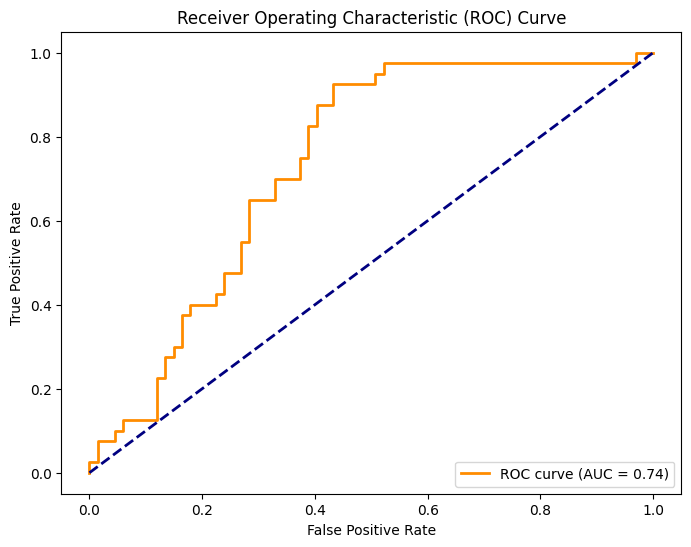

In [38]:
best_estimator = grid_search.best_estimator_
print(f"Best params = {grid_search.best_params_}")
y_pred = best_estimator.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('AUROC:', roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cv_scores = cross_val_score(best_estimator, X_train, y_train, cv=5, scoring='roc_auc')
print('Cross-validated ROC AUC scores:', cv_scores)
print('Mean cross-validated ROC AUC score:', cv_scores.mean())

y_train_pred = model.predict(X_train)
print('Train Accuracy:', accuracy_score(y_train, y_train_pred))
print('Train AUROC:', roc_auc_score(y_train, y_train_pred))
print('Train Classification Report:\n', classification_report(y_train, y_train_pred))

# Get predicted probabilities for the positive class
y_prob = best_estimator.decision_function(X_test)  # Use decision_function for SVM

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [39]:
from sklearn.model_selection import RandomizedSearchCV


# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=SVC(), param_distributions=param_grid, 
                                   n_iter=100, cv=5, scoring='roc_auc', n_jobs=-1, random_state=42)

# Fit the random search
random_search.fit(X_train, y_train)

# Results
best_estimator = random_search.best_estimator_
print(f"Best params = {random_search.best_params_}")

# Predict on the test data
y_pred = best_estimator.predict(X_test)
print('Test Accuracy:', accuracy_score(y_test, y_pred))
print('Test AUROC:', roc_auc_score(y_test, y_pred))
print('Test Classification Report:\n', classification_report(y_test, y_pred))

# Perform cross-validation and calculate the mean ROC AUC score
cv_scores = cross_val_score(best_estimator, X_train, y_train, cv=5, scoring='roc_auc')
print('Cross-validated ROC AUC scores:', cv_scores)
print('Mean cross-validated ROC AUC score:', cv_scores.mean())

# Predict on the train data
y_train_pred = best_estimator.predict(X_train)
print('Train Accuracy:', accuracy_score(y_train, y_train_pred))
print('Train AUROC:', roc_auc_score(y_train, y_train_pred))
print('Train Classification Report:\n', classification_report(y_train, y_train_pred))

Best params = {'kernel': 'linear', 'gamma': 0.1, 'degree': 3, 'C': 0.1}
Test Accuracy: 0.6074766355140186
Test AUROC: 0.5102611940298508
Test Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.90      0.74        67
           1       0.42      0.12      0.19        40

    accuracy                           0.61       107
   macro avg       0.52      0.51      0.47       107
weighted avg       0.55      0.61      0.54       107

Cross-validated ROC AUC scores: [0.60380117 0.63099415 0.59210526 0.64802632 0.58459259]
Mean cross-validated ROC AUC score: 0.6119038986354777
Train Accuracy: 0.6616915422885572
Train AUROC: 0.5692906615152658
Train Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.93      0.78       379
           1       0.64      0.21      0.32       224

    accuracy                           0.66       603
   macro avg       0.65      0.57      0.55     

## Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
log_reg = LogisticRegression(max_iter=500)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],  # L1 for Lasso, L2 for Ridge # 'liblinear' is a good choice for small datasets
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, 
                           cv=5, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Get the best estimator
best_estimator = grid_search.best_estimator_
print(f"Best params = {grid_search.best_params_}")

# Make predictions
y_pred = best_estimator.predict(X_test)

# Evaluate the mode

Best params = {'C': 0.01, 'penalty': 'l2'}


/home/hep/lprate/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/home/hep/lprate/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/hep/lprate/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hep/lprate/miniconda3/lib/python3.12/site-packages/sklearn/line

Accuracy: 0.5981308411214953
AUROC: 0.5128731343283582
              precision    recall  f1-score   support

           0       0.63      0.85      0.73        67
           1       0.41      0.17      0.25        40

    accuracy                           0.60       107
   macro avg       0.52      0.51      0.49       107
weighted avg       0.55      0.60      0.55       107

Cross-validated ROC AUC scores: [0.6251462  0.61403509 0.63947368 0.65699761 0.55525926]
Mean cross-validated ROC AUC score: 0.6181823675349991
Train Accuracy: 0.8805970149253731
Train AUROC: 0.8475016490765171
Train Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91       379
           1       0.95      0.72      0.82       224

    accuracy                           0.88       603
   macro avg       0.90      0.85      0.86       603
weighted avg       0.89      0.88      0.88       603



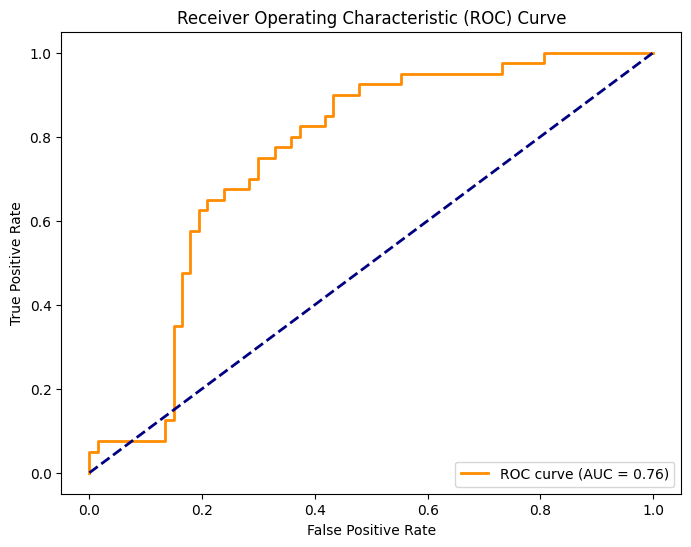

In [42]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('AUROC:', roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cv_scores = cross_val_score(best_estimator, X_train, y_train, cv=5, scoring='roc_auc')
print('Cross-validated ROC AUC scores:', cv_scores)
print('Mean cross-validated ROC AUC score:', cv_scores.mean())

# Predict on the train data
y_train_pred = model.predict(X_train)
print('Train Accuracy:', accuracy_score(y_train, y_train_pred))
print('Train AUROC:', roc_auc_score(y_train, y_train_pred))
print('Train Classification Report:\n', classification_report(y_train, y_train_pred))

plot_roc_curve(best_estimator, X_test, y_test)

# NN

In [43]:
import torch
class Model(torch.nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.linear = torch.nn.Linear(input_dim, 25)
        self.linear2 = torch.nn.Linear(25, 1)
        self.acti = torch.nn.ReLU()
    def forward(self, x):
        return (self.linear2(self.acti(self.linear(x))))
    def predict_proba(self, x):
        return torch.sigmoid(self.forward(x))

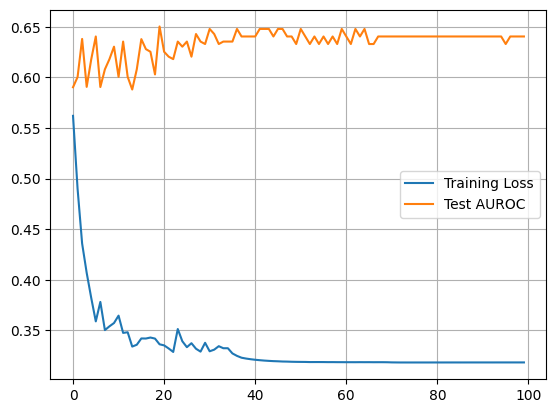

Test AUROC: 0.6405
Train Accuracy: 0.9087893864013267
Train AUROC: 0.8927511307953261
Train Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.96      0.93       379
         1.0       0.92      0.83      0.87       224

    accuracy                           0.91       603
   macro avg       0.91      0.89      0.90       603
weighted avg       0.91      0.91      0.91       603

Test Accuracy: 0.6822429906542056
Test AUROC: 0.6404850746268657
Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.81      0.76        67
         1.0       0.59      0.47      0.53        40

    accuracy                           0.68       107
   macro avg       0.66      0.64      0.64       107
weighted avg       0.67      0.68      0.67       107



In [44]:
import torch
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

import torch.nn as nn
import torch.optim as optim

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Define the model, loss function, and optimizer
model_nn = Model(X_train.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_nn.parameters(), lr=0.1, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=350, gamma=0.1)

# Training loop
num_epochs = 1000
loss_train = []
auroc_test = []
for epoch in range(num_epochs):
    model_nn.train()
    optimizer.zero_grad()
    outputs = model_nn(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        loss_train.append(loss.item())
        model_nn.eval()
        with torch.no_grad():
            test_outputs = model_nn(X_test_tensor)
            test_preds = torch.round(torch.sigmoid(test_outputs))
            test_roc_auc = roc_auc_score(y_test_tensor, test_preds)
            #print(f'Test AUROC: {test_roc_auc:.4f}')
            auroc_test.append(test_roc_auc)
    scheduler.step()
plt.plot(loss_train, label='Training Loss')
plt.plot(auroc_test, label='Test AUROC')
plt.grid()
plt.legend()
plt.show()


# Evaluation on train data
model_nn.eval()
with torch.no_grad():
    test_outputs = model_nn(X_test_tensor)
    test_preds = torch.round(torch.sigmoid(test_outputs))
    test_roc_auc = roc_auc_score(y_test_tensor, test_preds)
    print(f'Test AUROC: {test_roc_auc:.4f}')
    train_outputs = model_nn(X_train_tensor)
    train_preds = torch.round(torch.sigmoid(train_outputs))
    train_accuracy = accuracy_score(y_train_tensor, train_preds)
    train_roc_auc = roc_auc_score(y_train_tensor, train_preds)
    print('Train Accuracy:', train_accuracy)
    print('Train AUROC:', train_roc_auc)
    print('Train Classification Report:\n', classification_report(y_train_tensor, train_preds))

# Evaluation on test data
with torch.no_grad():
    test_outputs = model_nn(X_test_tensor)
    test_preds = torch.round(torch.sigmoid(test_outputs))
    test_accuracy = accuracy_score(y_test_tensor, test_preds)
    test_roc_auc = roc_auc_score(y_test_tensor, test_preds)
    print('Test Accuracy:', test_accuracy)
    print('Test AUROC:', test_roc_auc)
    print('Test Classification Report:\n', classification_report(y_test_tensor, test_preds))

